## The data grabbed from UHF antenna

The Parallella (Pcko) grabbing unit was used to capture triggered data from loop antennas.

In [73]:
# Tato bunka slouzi pro papermill, je oznacena tagem 'parameters'

path = "/storage/experiments/2022/0714_bourka_krivoklatsko_CAR2/parallella/"

session = [
    "/storage/experiments/2022/0714_bourka_krivoklatsko_CAR2/parallella/",
    "/storage/experiments/2022/0714_bourka_horovice_CAR1/parallella/",
    "/storage/experiments/2022/0714_bourka_CAR0/parallella/"
]

session = [
    "/storage/experiments/2022/0907_bourka_CAR0/parallella-vlf/",
    "/storage/experiments/2022/0907_bourka_CAR1/parallella/"
    "/storage/experiments/2022/0907_bourka_CAR2/parallella-VLF/"
]

session 

['/storage/experiments/2022/0907_bourka_CAR0/parallella-vlf/',
 '/storage/experiments/2022/0907_bourka_CAR1/parallella//storage/experiments/2022/0907_bourka_CAR2/parallella-VLF/']

In [ ]:
import os
import sys
from readrec import *
import matplotlib
from scipy.signal import find_peaks


sps = 10e6 # 10 Msps

In [4]:
# Coincidence detector
import pandas as pd
import numpy as np
from readrec import *



#car0 = pd.read_csv("/storage/experiments/2022/0826_bourka_staryvestec_CAR0/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
#car1 = pd.read_csv("/storage/experiments/2022/0826_bourka_staryvestec_CAR1/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
#car2 = pd.read_csv("/storage/experiments/2022/0826_bourka_staryvestec_CAR2/triggers.csv", delimiter=";", names =["file", "datetime", "na"])

#car0 = pd.read_csv("/storage/experiments/2022/0907_bourka_CAR0/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
#car1 = pd.read_csv("/storage/experiments/2022/0907_bourka_CAR1/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
#car2 = pd.read_csv("/storage/experiments/2022/0907_bourka_CAR2/triggers.csv", delimiter=";", names =["file", "datetime", "na"])


car0 = pd.read_csv("/storage/experiments/2022/0909_bourka_CAR0/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
car1 = pd.read_csv("/storage/experiments/2022/0909_bourka_CAR1/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
car2 = pd.read_csv("/storage/experiments/2022/0909_bourka_CAR2/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
out = "/storage/experiments/2022/0909_bourka_compare/"


#car0 = pd.read_csv("/storage/experiments/2022/0909_bourka_CAR0/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
car1 = pd.read_csv("/storage/experiments/2022/0914_bourka_CAR1/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
car2 = pd.read_csv("/storage/experiments/2022/0914_bourka_CAR2/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
out = "/storage/experiments/2022/0914_bourka_compare/"


car0 = pd.read_csv("/storage/experiments/2022/1018_bourka_CAR0/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
#car1 = pd.read_csv("/storage/experiments/2022/0914_bourka_CAR1/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
car2 = pd.read_csv("/storage/experiments/2022/1018_bourka_CAR2/triggers.csv", delimiter=";", names =["file", "datetime", "na"])
out = "/storage/experiments/2022/1019_bourka_compare/"

car1["car"] = "CAR1"
car2["car"] = "CAR2"
car0["car"] = "CAR0"

In [5]:
# Upravit sadu aut dle měření

#cars = pd.concat([car0, car1, car2])
cars = pd.concat([car1, car2])
cars['ts'] = pd.to_datetime(cars['datetime'], utc=True)
cars = cars.sort_values(by=['ts']).reset_index()
cars['diff'] = cars['ts'].diff()
cars

try:
    import os
    os.mkdir(out)
except:
    pass

In [6]:
def multistation_plotrec(files):
    
    channels = [0,1,3]
    fig, (ax) = plt.subplots(figsize=(35, 20), nrows=len(channels)*len(files), sharex=True)
    title = None
    
    data = {f:{"filename": f} for f in files}
    print(data)
    
    mintime = None
    
    for j, filepath in enumerate(data):
        print(j, filepath)
        try:
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)
                h, samples, synclog = loadrec(file)
                t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)

                time = s2t(0)
                if not mintime:
                    mintime = time
                if mintime > time:
                    mintime = time
        except Exception as e:
            print("Vyjimka 1", e)


    print("Znam minimalni cas", mintime)
    
    for j, filepath in enumerate(data):
        print(j, filepath)
        try:
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)

                h, samples, synclog = loadrec(file)
                t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
                print("zacatek", s2t(0))
                offset = -int(t2s(mintime))
                #print("offset", offset)

                if title is not None:
                    fig.suptitle(title)

                for i, ch in enumerate(channels):
                    i += len(channels)*j
                    #print(i)

                    pre_trigger_blocks = h['preTrigger']
                    post_trigger_blocks = h['postTrigger']

                    a = (h['preTrigger']-pre_trigger_blocks)*h['descSpan']//16 #select block of samples before trigger
                    b = (h['preTrigger']+post_trigger_blocks)*h['descSpan']//16  #select blocks after trigger 
                    #print(a, b)

                    signal_samples = samples[a:b,ch]
                    #print(a, b, len(samples[:,0]))

                    axis_plotrec(ax[i], h, signal_samples, a+offset, b+offset, ticker, formatter, str("{}, channel: {}".format(filepath, ch)))
        except Exception as e:
            print("Vyjimka", e)
        print("Done", fn)

    return fig

In [7]:
import datetime
clusters = []
opened = False
deltasec = 2
log = open(out+"groups.txt", "w")

for i, r in enumerate(cars[::-1].iterrows()):
    j, d = r
    #print(i, d['diff'])
    if d['diff'] < datetime.timedelta(seconds=deltasec) or opened:
        if not opened:
            clusters.append([])
            print(".......")
            log.write("\r")
            opened = True
        if opened:
            clusters[-1].append(r)
            print(d['diff'].total_seconds(), d['car'], d['file'])
            log.write("{},{},{},{}\r".format(d['datetime'], d['car'], d['diff'].total_seconds(), d['file']))
        if not d['diff'] < datetime.timedelta(seconds=deltasec):
            opened = False
    else:
        opened = False
log.close()
#clusters

.......
0.83 CAR2 /storage/experiments/2022/1018_bourka_CAR2/parallella-VLF/rec_221018-163826.77
1.38 CAR2 /storage/experiments/2022/1018_bourka_CAR2/parallella-VLF/rec_221018-163825.94
9.43 CAR2 /storage/experiments/2022/1018_bourka_CAR2/parallella-VLF/rec_221018-163824.56
.......
1.98 CAR2 /storage/experiments/2022/1018_bourka_CAR2/parallella-VLF/rec_221018-163815.13
2.5 CAR2 /storage/experiments/2022/1018_bourka_CAR2/parallella-VLF/rec_221018-163813.15
.......
1.66 CAR2 /storage/experiments/2022/1018_bourka_CAR2/parallella-VLF/rec_221018-163801.63
17.32 CAR2 /storage/experiments/2022/1018_bourka_CAR2/parallella-VLF/rec_221018-163759.97


In [ ]:
for c in clusters:
    if len(c) > 2:
        print(c)


In [79]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import os 

#os.mkdir(out)
clusters.sort(key=len)
for i, x in enumerate(reversed(clusters)):
    try:
        plt.cla()
        plt.clf()
        if len(x) > 1:
            paths = []
            print("..........")
            for p in x:
                #print(p[1]['file']) 
                paths.append(p[1]['file'])
            print(">>", paths)
            multistation_plotrec(paths)
            print("Ukladam", out+str(i)+".png")
            filename = os.path.basename(p[1]['file'])
            plt.savefig(out+filename+".png")
            print("Ulozeno")
            #plt.xlim(14614528/20*2, 14614528/6)
            #plt.show()
    except Exception as e:
        print("chyba", e)

..........
>> ['/storage/experiments/2022/0914_bourka_CAR1/parallella-vlf/rec_220914-183929.47', '/storage/experiments/2022/0914_bourka_CAR2/parallella-vlf/rec_220914-183929.47']
{'/storage/experiments/2022/0914_bourka_CAR1/parallella-vlf/rec_220914-183929.47': {'filename': '/storage/experiments/2022/0914_bourka_CAR1/parallella-vlf/rec_220914-183929.47'}, '/storage/experiments/2022/0914_bourka_CAR2/parallella-vlf/rec_220914-183929.47': {'filename': '/storage/experiments/2022/0914_bourka_CAR2/parallella-vlf/rec_220914-183929.47'}}
0 /storage/experiments/2022/0914_bourka_CAR1/parallella-vlf/rec_220914-183929.47
1 /storage/experiments/2022/0914_bourka_CAR2/parallella-vlf/rec_220914-183929.47
Znam minimalni cas 2022-09-14 18:39:28.743510300
0 /storage/experiments/2022/0914_bourka_CAR1/parallella-vlf/rec_220914-183929.47
zacatek 2022-09-14 18:39:28.744954800
Done rec_220914-183929.47
1 /storage/experiments/2022/0914_bourka_CAR2/parallella-vlf/rec_220914-183929.47
zacatek 2022-09-14 18:39:28

/tmp/ipykernel_21774/1053898871.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax) = plt.subplots(figsize=(35, 20), nrows=len(channels)*len(files), sharex=True)


1 /storage/experiments/2022/0914_bourka_CAR1/parallella-vlf/rec_220914-185459.50
Znam minimalni cas 2022-09-14 18:54:58.771970900
0 /storage/experiments/2022/0914_bourka_CAR2/parallella-vlf/rec_220914-185500.62
zacatek 2022-09-14 18:54:59.893281300
Done rec_220914-185500.62
1 /storage/experiments/2022/0914_bourka_CAR1/parallella-vlf/rec_220914-185459.50
zacatek 2022-09-14 18:54:58.771970900
Done rec_220914-185459.50
Ukladam /storage/experiments/2022/0914_bourka_compare/5.png
Ulozeno
..........
>> ['/storage/experiments/2022/0914_bourka_CAR1/parallella-vlf/rec_220914-185942.36', '/storage/experiments/2022/0914_bourka_CAR2/parallella-vlf/rec_220914-185942.36']
{'/storage/experiments/2022/0914_bourka_CAR1/parallella-vlf/rec_220914-185942.36': {'filename': '/storage/experiments/2022/0914_bourka_CAR1/parallella-vlf/rec_220914-185942.36'}, '/storage/experiments/2022/0914_bourka_CAR2/parallella-vlf/rec_220914-185942.36': {'filename': '/storage/experiments/2022/0914_bourka_CAR2/parallella-vlf/

# Pokus o autokorelaci 

['/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-142219.77', '/storage/experiments/2022/0909_bourka_CAR0/parallella-vlf/rec_220909-142219.77']
{'/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-142219.77': {'filename': '/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-142219.77'}, '/storage/experiments/2022/0909_bourka_CAR0/parallella-vlf/rec_220909-142219.77': {'filename': '/storage/experiments/2022/0909_bourka_CAR0/parallella-vlf/rec_220909-142219.77'}}
0 /storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-142219.77
1 /storage/experiments/2022/0909_bourka_CAR0/parallella-vlf/rec_220909-142219.77
Znam minimalni cas 2022-09-09 14:22:19.045775900
0 /storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-142219.77
zacatek 2022-09-09 14:22:19.045995800
Done rec_220909-142219.77
1 /storage/experiments/2022/0909_bourka_CAR0/parallella-vlf/rec_220909-142219.77
zacatek 2022-09-09 14:22:19.045775900
Don

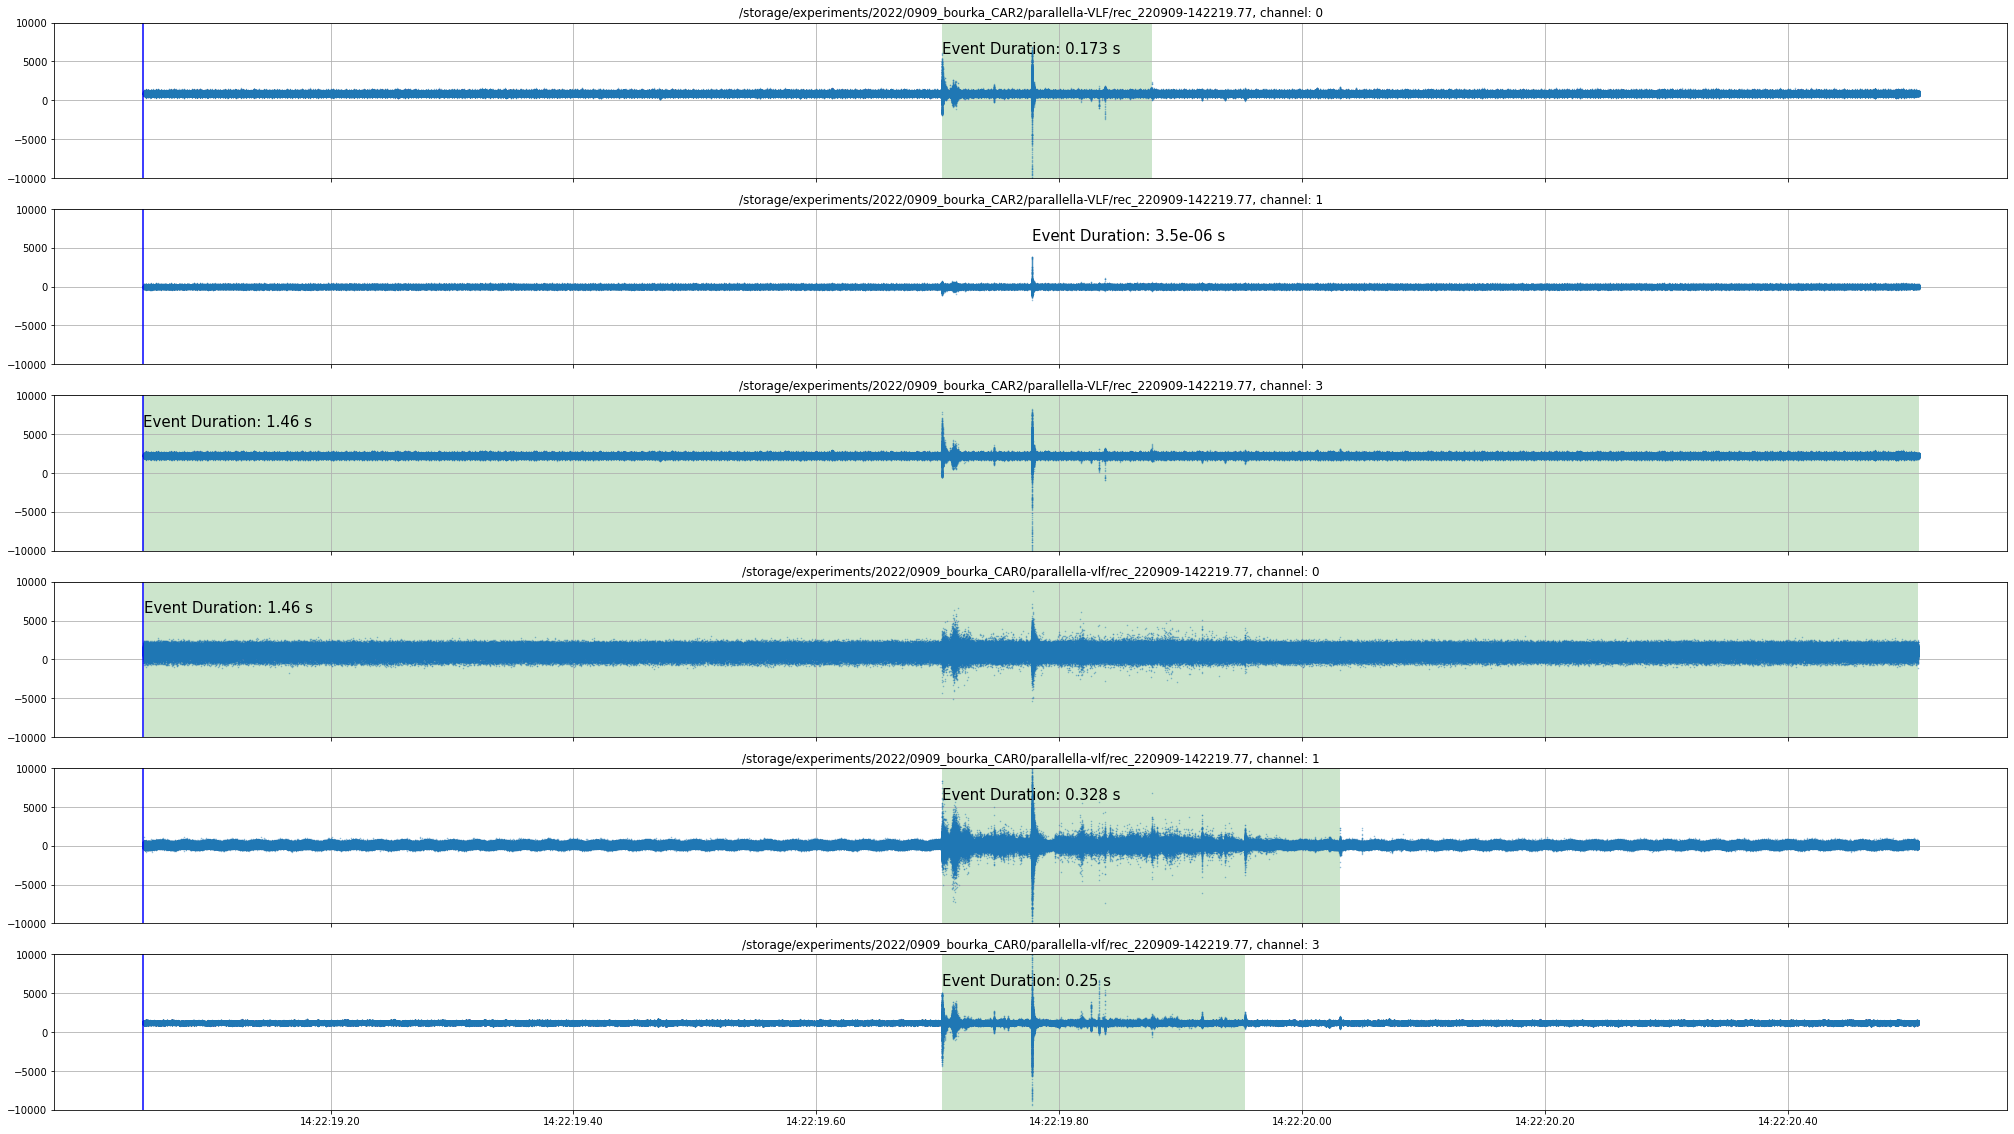

In [9]:
group = clusters[113]
paths = []
for i, record in enumerate(group):
    paths.append(record[1]['file'])
#    fn = os.path.basename(record[1]['file'])
#    h, samples, synclog = loadrec(open(record[1]['file'], 'rb'))
    #t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
    
#    print(samples.shape)
print(paths)

multistation_plotrec(paths)

Plot all lightning records (High memory and time consuming)

In [12]:
rd = []
for p in paths:
    fn = os.path.basename(p)
    h, samples, synclog = loadrec(open(p, 'rb'))
    t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
    
    i = {'h': h, 'samples': samples, 'synclog': synclog, "t2s": t2s, "s2t": s2t, "ticker": ticker, "formatter": formatter}
    rd.append(i)

In [45]:
from scipy import signal

# 1ms window
ms = 10000000/1000

win_l = ms
max_sweep = ms*100


In [57]:
refs = np.array(rd[0]['samples'])[int(10000000*0.5):int(10000000*0.9)]
refs = refs[:,0]+refs[:,1]+refs[:,3]

comps = np.array(rd[1]['samples'])[int(10000000*0.5):int(10000000*0.9)]
comps = comps[:,0]+comps[:,1]+comps[:,3]

output = np.ndarray((int(refs.shape[0]/win_l*2), int(max_sweep*2)))

#plt.plot(refs)

In [58]:
refs

array([3488, 3424, 3360, ..., 2848, 2848, 2864], dtype=int16)

In [59]:
for window_i in range(int(refs.shape[0]/win_l*2)):
    sample_num = window_i/2*win_l
    #for sweep_i in range(int(-max_sweep), int(max_sweep)):
    conv = signal.convolve(refs, comps[int(sample_num):int(sample_num+win_l)] , mode='same', method='direct').T
    conv.shape    
        

KeyboardInterrupt: 